In [1]:
from pathlib import Path
import re, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
root = Path(r"C:\Users\garvi\.cache\kagglehub\datasets\sorour\95cloud-cloud-segmentation-on-satellite-images\versions\3\95-cloud_training_only_additional_to38-cloud")
# root=Path(r"C:\Users\garvi\.cache\kagglehub\datasets\sorour\38cloud-cloud-segmentation-in-satellite-images\versions\4\38-Cloud_test")
# exact folder names in your printout
red_dir   = root / "train_red_additional_to38cloud"
green_dir = root / "train_green_additional_to38cloud"
blue_dir  = root / "train_blue_additional_to38cloud"
nir_dir   = root / "train_nir_additional_to38cloud"
gt_dir    = root / "train_gt_additional_to38cloud"
# red_dir   = root / "train_red"
# green_dir = root / "train_green"
# blue_dir  = root / "train_blue"
# nir_dir   = root / "train_nir"
# gt_dir    = root / "train_gt"

In [3]:
print(red_dir)

C:\Users\garvi\.cache\kagglehub\datasets\sorour\95cloud-cloud-segmentation-on-satellite-images\versions\3\95-cloud_training_only_additional_to38-cloud\train_red_additional_to38cloud


In [24]:
image_path="_patch_182_9_by_14_LC08_L1TP_045020_20160720_20170221_01_T1.TIF"
image_path_r="red"+image_path
image_path_g="green"+image_path
image_path_b="blue"+image_path
image_path_nir="nir"+image_path
image_path_gt="gt"+image_path

In [25]:
image_path_r=red_dir/image_path_r
image_path_g=green_dir/image_path_g
image_path_b=blue_dir/image_path_b
image_path_nir=nir_dir/image_path_nir
image_path_gt=gt_dir/image_path_gt

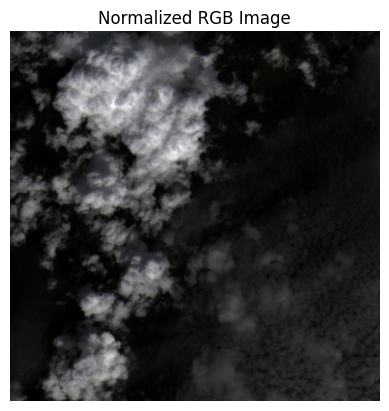

In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load
R = np.array(Image.open(image_path_r)).astype(np.float32)
G = np.array(Image.open(image_path_g)).astype(np.float32)
B = np.array(Image.open(image_path_b)).astype(np.float32)
N = np.array(Image.open(image_path_nir)).astype(np.float32)

# Normalize each band to 0–1
def normalize(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x

R = normalize(R)
G = normalize(G)
B = normalize(B)
N = normalize(N)

# Stack as RGB
rgb = np.stack([R, G, B], axis=-1)
img = np.stack([R, G, B, N], axis=0)  
img_tensor = torch.tensor(img).unsqueeze(0)  

# Display
plt.imshow(rgb)
plt.title("Normalized RGB Image")
plt.axis("off")
plt.show()


In [27]:
import torch

In [28]:
from models import UNetSmall

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "Unet/models/model_3.pt"

model = UNetSmall(in_ch=4, out_ch=1).to(device)

ckpt = torch.load(path, map_location=device)

state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt

model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [42]:
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(img_tensor))  # (1, 1, H, W)


In [43]:
pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()

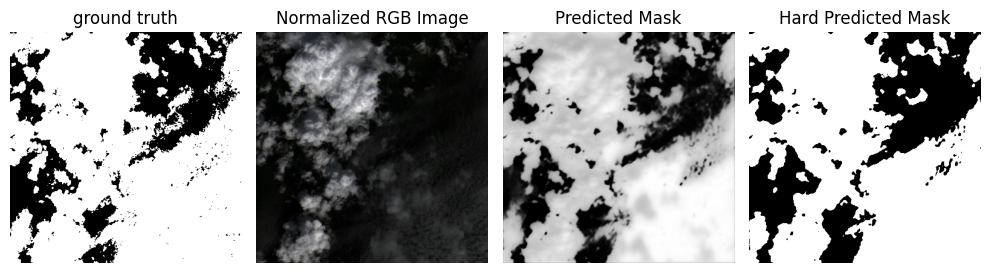

In [44]:
img = Image.open(image_path_gt).convert('L')
plt.figure(figsize=(10, 5))    
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("ground truth")

plt.subplot(1, 4, 2)
plt.imshow(rgb)
plt.title("Normalized RGB Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred.float().squeeze().cpu().numpy(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(pred_mask, cmap="gray")
plt.title("Hard Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

In [45]:
print(np.max(pred.float().squeeze().cpu().numpy()))
print(np.min(pred.float().squeeze().cpu().numpy()))
print(np.sum(pred.float().squeeze().cpu().numpy()))

0.7991665
5.8321293e-05
72682.164


In [46]:
t=img/np.max(img)
p=pred.float().squeeze().cpu().numpy()
# per-pixel stats on positives vs negatives
if t.max() > 1:
    t = (t > 127).astype(np.uint8)
pos_probs = p[t==1]
neg_probs = p[t==0]
print("pos mean/median:", pos_probs.mean(), np.median(pos_probs))
print("neg mean/median:", neg_probs.mean(), np.median(neg_probs))

pos mean/median: 0.6334702 0.6491345
neg mean/median: 0.10621771 0.032400437
